# PyTorch Assignment: Convolutional Neural Network (CNN)

**[Duke Community Standard](http://integrity.duke.edu/standard.html): By typing your name below, you are certifying that you have adhered to the Duke Community Standard in completing this assignment.**

Name: Vinicius Kenji Yamada

### Convolutional Neural Network

Adapt the CNN example for MNIST digit classfication. 
Feel free to play around with the model architecture and see how the training time/performance changes, but to begin, try the following:

Image ->  
convolution (32 3x3 filters) -> nonlinearity (ReLU) ->  
convolution (32 3x3 filters) -> nonlinearity (ReLU) -> (2x2 max pool) ->  
convolution (64 3x3 filters) -> nonlinearity (ReLU) ->  
convolution (64 3x3 filters) -> nonlinearity (ReLU) -> (2x2 max pool) -> flatten ->
fully connected (256 hidden units) -> nonlinearity (ReLU) ->  
fully connected (10 hidden units) -> softmax 

Note: The CNN model might take a while to train. Depending on your machine, you might expect this to take up to half an hour. If you see your validation performance start to plateau, you can kill the training.

In [22]:
### Import Libraries ###
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

In [2]:
### CUDA ###
print(torch.cuda.is_available())
print(torch.cuda.current_device())

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

True
0


In [117]:
### Model ###
class MNIST_CNN_assingment(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(7*7*64, 256)
        self.fc2 = nn.Linear(256, 10)


    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)

        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)

        x = self.conv3(x)
        x = F.relu(x)
        
        x = self.conv4(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)

        x = x.view(-1, 7*7*64)

        x = self.fc1(x)
        x = F.relu(x)

        x = self.fc2(x)

        return(x)
    

In [148]:
### Training ###

mnist_train = datasets.MNIST(root="./datasets", train=True, transform=transforms.ToTensor(), download=True)
mnist_test = datasets.MNIST(root="./datasets", train=False, transform=transforms.ToTensor(), download=True)
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=100, shuffle=True)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=100, shuffle=False)

model = MNIST_CNN_assingment().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(5):
    correct = 0
    total = len(mnist_train)

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()

        x = images
        y = model(x)

        predictions = torch.argmax(y, dim=1)
        correct += torch.sum((predictions == labels).float())
        loss = criterion(y, labels)

        loss.backward()
        optimizer.step()
    print("Epoch {} accuracy: {:.2f}%".format(epoch+1, (correct/total)*100))

Epoch 1 accuracy: 94.20%
Epoch 2 accuracy: 98.64%
Epoch 3 accuracy: 99.11%
Epoch 4 accuracy: 99.26%
Epoch 5 accuracy: 99.46%


In [150]:
### Testing ###
correct = 0
total = len(mnist_test)

with torch.no_grad():
    # Iterate through test set minibatchs 
    for index, (images, labels) in enumerate(test_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        x = images  # <---- change here 
        y = model(x)
        predictions = torch.argmax(y, dim=1)
        correct += torch.sum((predictions == labels).float())

print('Test accuracy: {:.2f}%'.format((correct/total)*100))

Test accuracy: 99.10%


In [142]:
### Individual testing ###
def single_test(test_index, model):
    test_image = mnist_test.data[test_index]
    test_label = mnist_test.targets[test_index]

    x = ((test_image.view(1, 1, 28, 28)).type('torch.FloatTensor')).to(device)
    y = model(x)
    
    prediction = int(torch.argmax(y, dim=1))

    return prediction == test_label

def print_test(test_index, model):
    test_image = mnist_test.data[test_index]
    test_label = mnist_test.targets[test_index]

    smax = nn.Softmax(dim = 1)

    image_output = np.array(test_image)
    plt.imshow(image_output, cmap = 'gray')
    plt.show()

    x = ((test_image.view(1, 1, 28, 28)).type('torch.FloatTensor')).to(device)
    y = model(x)

    prob = smax(y/1000)
    prob_max = torch.max(prob)
    prediction = int(torch.argmax(y, dim=1))

    print("Prediction: {} ({:.2f}% confidence)\n".format(prediction, prob_max*100))
    print("Probabilities: {}\n".format(prob))
    print("Label: {}".format(test_label))

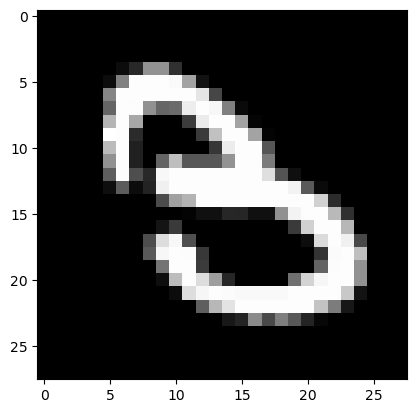

Prediction: 5 (45.99% confidence)

Probabilities: tensor([[0.0146, 0.0204, 0.0199, 0.3266, 0.0092, 0.4599, 0.0065, 0.0275, 0.0794,
         0.0360]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

Label: 3


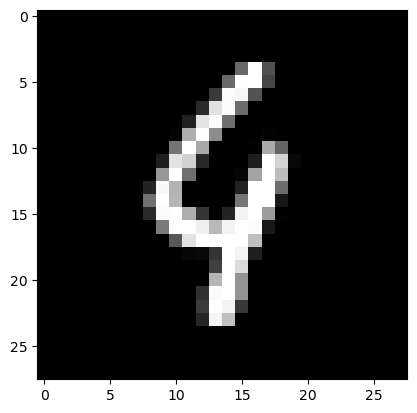

Prediction: 9 (42.99% confidence)

Probabilities: tensor([[0.0078, 0.0161, 0.0198, 0.0199, 0.2828, 0.0554, 0.0203, 0.0223, 0.1259,
         0.4299]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

Label: 4


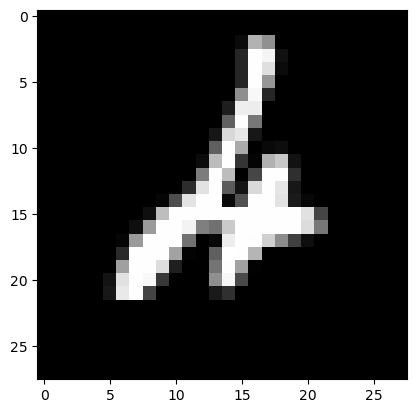

Prediction: 2 (43.14% confidence)

Probabilities: tensor([[0.0095, 0.0549, 0.4314, 0.0189, 0.2006, 0.0431, 0.1528, 0.0159, 0.0629,
         0.0100]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

Label: 4


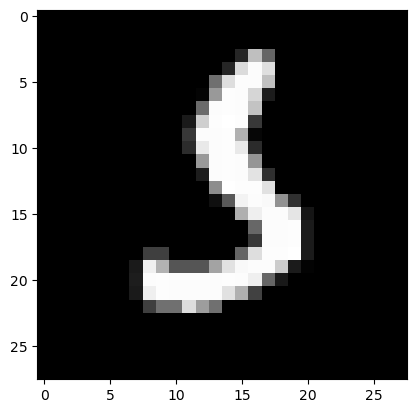

Prediction: 3 (44.93% confidence)

Probabilities: tensor([[0.0121, 0.0530, 0.0124, 0.4493, 0.0092, 0.3626, 0.0368, 0.0085, 0.0306,
         0.0256]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

Label: 5


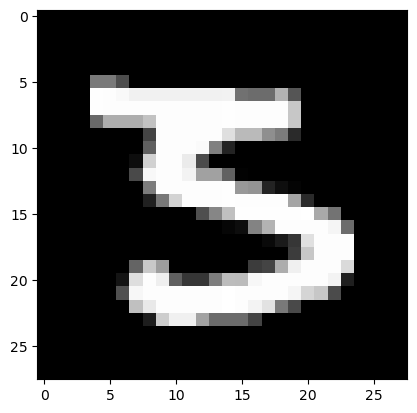

Prediction: 5 (56.95% confidence)

Probabilities: tensor([[0.0012, 0.0127, 0.0032, 0.3805, 0.0018, 0.5695, 0.0032, 0.0108, 0.0082,
         0.0090]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

Label: 3


In [143]:
### Check incorrect predictions ###
i = 0
j = 0
while (i < 5):
    if (not single_test(j, model)):
        print_test(j, model)
        i += 1
    j += 1
    